In [ ]:
import torch
import torch.nn.functional as F
from torch import nn, optim
from tqdm import tqdm
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

proj_dim = 128
prototypes_per_class = 2
sigma = 0.5
lambda_div = 0.01
sigma_div = 0.5


In [1]:
class AffinityLoss(nn.Module):
    """
    Affinity Loss (prototype-based, Gaussian affinity).
    - Each class has M prototypes in R^D (learned).
    - Class score = logsumexp over affinities to that class's prototypes.
    - Loss = CrossEntropy over class scores (+ optional diversity penalty).

    Args:
        num_classes:      C
        feat_dim:         D
        prototypes_per_class: M
        sigma:            Gaussian sigma for affinity (in feature space units)
        lambda_div:       weight for diversity regularizer (intra-class prototype repulsion)
        sigma_div:        sigma for diversity penalty (distance scale)
        device:           torch device
    """
    def __init__(self, num_classes:int, feat_dim:int, prototypes_per_class:int=2,
                 sigma:float=0.5, lambda_div:float=0.0, sigma_div:float=0.5, device="cpu"):
        super().__init__()
        self.C = num_classes
        self.D = feat_dim
        self.M = prototypes_per_class
        self.sigma2 = sigma * sigma
        self.lambda_div = lambda_div
        self.sigma_div2 = sigma_div * sigma_div

        # (C, M, D)
        self.prototypes = nn.Parameter(torch.randn(self.C, self.M, self.D, device=device) * 0.01)

    def forward(self, feats: torch.Tensor, labels: torch.Tensor):
        """
        feats:  (N, D)
        labels: (N,) long
        returns: (loss, class_logits) where class_logits is (N, C)
        """
        # distances to prototypes: (N, C, M)
        # Expand and compute squared L2
        N = feats.size(0)
        x = feats.unsqueeze(1).unsqueeze(2)                  # (N,1,1,D)
        p = self.prototypes.unsqueeze(0)                     # (1,C,M,D)
        d2 = torch.sum((x - p) ** 2, dim=-1)                 # (N,C,M)

        # Gaussian affinities per prototype
        # a_{c,m} = exp(-d2 / (2*sigma^2))
        a = torch.exp(-d2 / (2.0 * self.sigma2))             # (N,C,M)

        # Class score = logsumexp over prototypes per class
        # logits_c = log( sum_m a_{c,m} )
        class_logits = torch.log(torch.clamp(a.sum(dim=2), min=1e-12))  # (N,C)

        # Cross-entropy over classes
        ce = F.cross_entropy(class_logits, labels)

        # Diversity regularizer (optional): repel same-class prototypes
        div = torch.tensor(0.0, device=feats.device)
        if self.lambda_div > 0:
            # pairwise distances within each class: (C, M, M)
            pp = self.prototypes  # (C,M,D)
            # squared distances between all pairs m1,m2 within class
            diff = pp.unsqueeze(2) - pp.unsqueeze(1)         # (C,M,M,D)
            d2_pp = (diff ** 2).sum(dim=-1)                  # (C,M,M)
            # exclude diagonal; encourage larger distances -> penalize high affinity
            mask = 1 - torch.eye(self.M, device=feats.device).unsqueeze(0)  # (1,M,M)
            repulsion = torch.exp(-d2_pp / (2.0 * self.sigma_div2)) * mask
            div = repulsion.sum() / (self.C * self.M * (self.M - 1) + 1e-6)

        loss = ce + self.lambda_div * div
        return loss, class_logits



def train_one_epoch(features_fn, feat_proj, affinity, optimizer, loader, device):
    feat_proj.train()
    running = 0.0
    for imgs, labels in tqdm(loader, leave=False):
        imgs = imgs.to(device, non_blocking=True)
        y = labels.to(device, non_blocking=True).long()

        with torch.set_grad_enabled(True):
            with torch.no_grad():                      # backbone frozen
                f_backbone = features_fn(imgs)        # (N, D_backbone)
            f = feat_proj(f_backbone)                 # (N, D)
            loss, _ = affinity(f, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running += loss.item() * imgs.size(0)
    return running / len(loader.dataset)

@torch.no_grad()
def evaluate_epoch(features_fn, feat_proj, affinity, loader, device):
    feat_proj.eval()
    correct = total = 0
    total_loss = 0.0

    for imgs, labels in tqdm(loader, leave=False):
        imgs = imgs.to(device, non_blocking=True)
        y = labels.to(device, non_blocking=True).long()

        f = feat_proj(features_fn(imgs))             # (N, D)
        loss, class_logits = affinity(f, y)
        total_loss += loss.item() * imgs.size(0)

        preds = class_logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    return correct / total, total_loss / total


# Use ImageNet normalization for pretrained ViT
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

train_dir = "data_classification/augmented/train"
test_dir  = "data_classification/augmented/test"

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset  = datasets.ImageFolder(root=test_dir,  transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True,  num_workers=4, pin_memory=True)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size=128, shuffle=False, num_workers=4, pin_memory=True)



In [2]:
swin = models.swin_b(pretrained=True).to(device)
for p in swin.parameters(): p.requires_grad = False
swin.eval()
feat_dim_backbone = swin.head.in_features  # 1024
swin.head = nn.Identity()                  # forward returns features now

def features_fn_swin(x):
    return swin(x)   # (N, 1024)

feat_proj = nn.Linear(feat_dim_backbone, proj_dim).to(device)
affinity = AffinityLoss(len(train_dataset.classes), proj_dim,
                        prototypes_per_class, sigma, lambda_div, sigma_div, device).to(device)

optimizer = optim.Adam([
    {"params": feat_proj.parameters(), "lr": 1e-3},
    {"params": affinity.parameters(), "lr": 5e-4},
])

/home/ai-17/miniconda3/envs/mmdet/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ai-17/miniconda3/envs/mmdet/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Swin_B_Weights.IMAGENET1K_V1`. You can also use `weights=Swin_B_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:

for ep in range(10):
    tr = train_one_epoch(features_fn_swin, feat_proj, affinity, optimizer, train_loader, device)
    acc, vl = evaluate_epoch(features_fn_swin, feat_proj, affinity, test_loader, device)
    print(f"[Swin] epoch {ep+1}: train {tr:.4f} | val {vl:.4f} | acc {acc:.3f}")


[Swin] epoch 1: train 0.4298 | val 0.3942 | acc 0.825


[Swin] epoch 2: train 0.3568 | val 0.4102 | acc 0.816


[Swin] epoch 3: train 0.3280 | val 0.3654 | acc 0.839


[Swin] epoch 4: train 0.3396 | val 0.3581 | acc 0.871


[Swin] epoch 5: train 0.2947 | val 0.3379 | acc 0.857


[Swin] epoch 6: train 0.2668 | val 0.3080 | acc 0.862


[Swin] epoch 7: train 0.2659 | val 0.3187 | acc 0.866


[Swin] epoch 8: train 0.3193 | val 0.3063 | acc 0.857


[Swin] epoch 9: train 0.2846 | val 0.3143 | acc 0.880


[Swin] epoch 10: train 0.2464 | val 0.3037 | acc 0.885


              precision    recall  f1-score   support

    Negative     0.9286    0.9108    0.9196       157
    Positive     0.7778    0.8167    0.7967        60

    accuracy                         0.8848       217
   macro avg     0.8532    0.8637    0.8582       217
weighted avg     0.8869    0.8848    0.8856       217

Confusion Matrix:
 [[143  14]
 [ 11  49]]


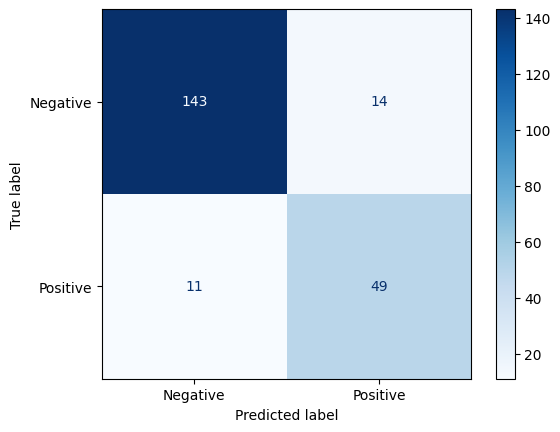

In [6]:
@torch.no_grad()
def evaluate_epoch(features_fn, feat_proj, affinity, loader, device):
    feat_proj.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    for imgs, labels in tqdm(loader, leave=False):
        imgs = imgs.to(device, non_blocking=True)
        y = labels.to(device, non_blocking=True).long()

        f = feat_proj(features_fn(imgs))             # (N, D)
        loss, class_logits = affinity(f, y)

        preds = class_logits.argmax(dim=1)

        all_labels.extend(y.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

    return all_labels, all_preds


labels, preds = evaluate_epoch(features_fn_swin, feat_proj, affinity, test_loader, device)

print(classification_report(labels, preds, target_names=train_dataset.classes, digits=4))

cm = confusion_matrix(labels, preds)
print("Confusion Matrix:\n", cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
disp.plot(cmap="Blues")
plt.show()
